In [ ]:
# import the necessary libraries
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D
from sklearn.metrics import classification_report, confusion_matrix
import warnings
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings("ignore")

In [ ]:
# Load the CSV data
data = pd.read_csv('Diagnostics.csv')
data = data.drop('FileName',axis=1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10646 entries, 0 to 10645
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Rhythm           10646 non-null  object
 1   Beat             10646 non-null  object
 2   PatientAge       10646 non-null  int64 
 3   Gender           10646 non-null  object
 4   VentricularRate  10646 non-null  int64 
 5   AtrialRate       10646 non-null  int64 
 6   QRSDuration      10646 non-null  int64 
 7   QTInterval       10646 non-null  int64 
 8   QTCorrected      10646 non-null  int64 
 9   RAxis            10646 non-null  int64 
 10  TAxis            10646 non-null  int64 
 11  QRSCount         10646 non-null  int64 
 12  QOnset           10646 non-null  int64 
 13  QOffset          10646 non-null  int64 
 14  TOffset          10646 non-null  int64 
dtypes: int64(12), object(3)
memory usage: 1.2+ MB


In [ ]:
data.shape

(10646, 15)

In [ ]:
data.describe()

,PatientAge,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
count,10646.000000,10646.000000,10646.00000,10646.000000,10646.000000,10646.000000,10646.000000,10646.000000,10646.000000,10646.000000,10646.000000,10646.000000
mean,59.186831,84.136107,92.57787,90.989292,384.150855,434.154048,39.620609,44.637704,13.839470,219.260567,264.755213,411.335995
std,18.030019,34.455349,60.09394,17.479540,59.226289,39.354182,41.212648,57.478092,5.676339,6.410413,8.362120,29.777404
min,4.000000,34.000000,0.00000,18.000000,114.000000,219.000000,-89.000000,-89.000000,5.000000,159.000000,249.000000,281.000000
25%,49.000000,57.000000,57.00000,80.000000,344.000000,408.000000,14.000000,19.000000,9.000000,216.000000,259.000000,392.000000
50%,62.000000,73.000000,72.00000,88.000000,390.000000,430.000000,46.000000,42.000000,12.000000,219.000000,264.000000,414.000000
75%,72.000000,104.000000,106.00000,98.000000,426.000000,456.000000,68.000000,62.000000,17.000000,224.000000,268.000000,432.000000
max,98.000000,263.000000,535.00000,256.000000,736.000000,760.000000,270.000000,270.000000,40.000000,240.000000,331.000000,582.000000


In [ ]:
data.isnull().sum()

Rhythm             0
Beat               0
PatientAge         0
Gender             0
VentricularRate    0
AtrialRate         0
QRSDuration        0
QTInterval         0
QTCorrected        0
RAxis              0
TAxis              0
QRSCount           0
QOnset             0
QOffset            0
TOffset            0
dtype: int64

In [ ]:
# Encode categorical variables (e.g., 'Gender')
encoder = LabelEncoder()
data['Gender'] = encoder.fit_transform(data['Gender'])
data['Beat'] = encoder.fit_transform(data['Beat'])

In [ ]:
# Prepare the input features (X) and target labels (y)
X = data[['Beat', 'PatientAge', 'Gender', 'VentricularRate', 'AtrialRate', 'QRSDuration', 'QTInterval', 'QTCorrected', 'RAxis', 'TAxis', 'QRSCount', 'QOnset', 'QOffset', 'TOffset']]
y = data['Rhythm']

In [ ]:
# Encode the target labels into numerical format
y = encoder.fit_transform(y)

In [ ]:
column_names = data.columns.tolist()
i=1
for col in X:
  unique_values = data[col].nunique()
  print(f'The number of unique values in {column_names[i]} is {unique_values}.')
  i+=1


The number of unique values in Beat is 742.
The number of unique values in PatientAge is 95.
The number of unique values in Gender is 2.
The number of unique values in VentricularRate is 189.
The number of unique values in AtrialRate is 253.
The number of unique values in QRSDuration is 80.
The number of unique values in QTInterval is 206.
The number of unique values in QTCorrected is 295.
The number of unique values in RAxis is 277.
The number of unique values in TAxis is 356.
The number of unique values in QRSCount is 35.
The number of unique values in QOnset is 62.
The number of unique values in QOffset is 68.
The number of unique values in TOffset is 206.


In [ ]:
# Removing duplicate rows
data.drop_duplicates(inplace=True)

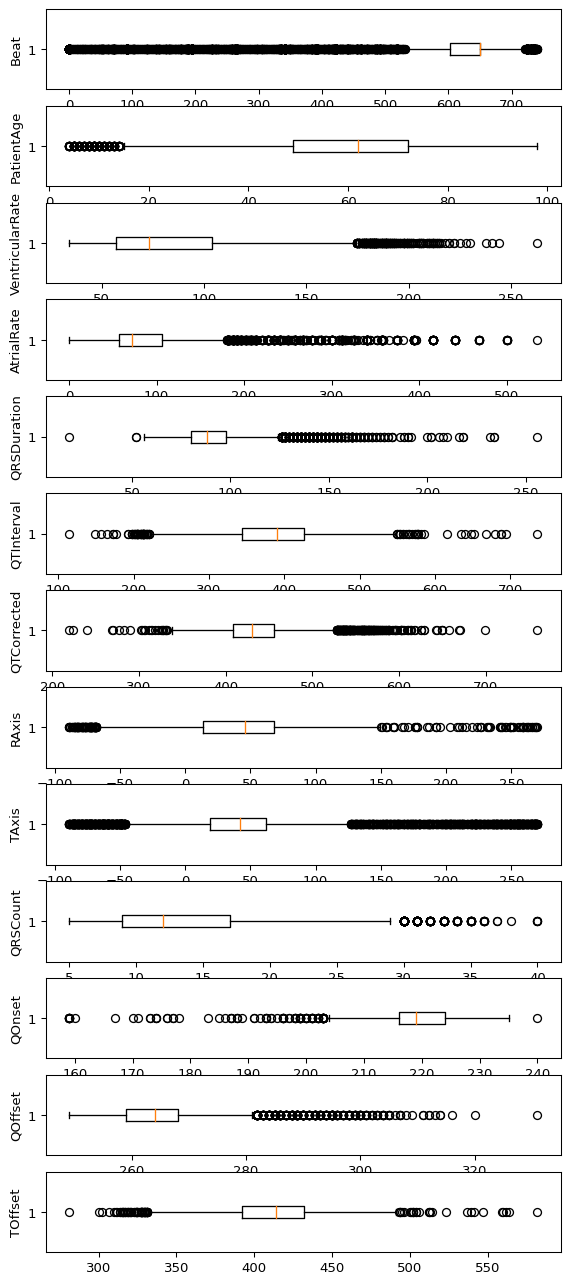

In [ ]:
import matplotlib.pyplot as plt

# Box Plots
box_features = ['Beat','PatientAge','VentricularRate','AtrialRate','QRSDuration','QTInterval','QTCorrected','RAxis','TAxis','QRSCount','QOnset','QOffset','TOffset']
fig, axs = plt.subplots(13,1,dpi=95, figsize=(7,17))
i = 0
for col in box_features:
	axs[i].boxplot(data[col], vert=False)
	axs[i].set_ylabel(col)
	i+=1
plt.show()

In [ ]:
column_names = data.columns.tolist()

i=1
for col in X:
  Q1=data[col].quantile(0.25)
  Q2=data[col].quantile(0.5)
  Q3=data[col].quantile(0.75)
  iqr=Q3-Q1
  lowlim=Q1-1.5*iqr
  upplim=Q3+1.5*iqr
  print(f'The upper limit and lower limit for {column_names[i]} is {upplim} and {lowlim}.')
  i+=1

The upper limit and lower limit for Beat is 720.5 and 532.5.
The upper limit and lower limit for PatientAge is 106.5 and 14.5.
The upper limit and lower limit for Gender is 2.5 and -1.5.
The upper limit and lower limit for VentricularRate is 174.5 and -13.5.
The upper limit and lower limit for AtrialRate is 179.5 and -16.5.
The upper limit and lower limit for QRSDuration is 125.0 and 53.0.
The upper limit and lower limit for QTInterval is 549.0 and 221.0.
The upper limit and lower limit for QTCorrected is 528.0 and 336.0.
The upper limit and lower limit for RAxis is 149.0 and -67.0.
The upper limit and lower limit for TAxis is 126.5 and -45.5.
The upper limit and lower limit for QRSCount is 29.0 and -3.0.
The upper limit and lower limit for QOnset is 236.0 and 204.0.
The upper limit and lower limit for QOffset is 281.5 and 245.5.
The upper limit and lower limit for TOffset is 492.0 and 332.0.


In [ ]:
column_names = data.columns.tolist()

i=1
for col in box_features:
  print(f'The skewiness of  {column_names[i]} is {data[col].skew()}.')
  i+=1

The skewiness of  Beat is -2.139234991882205.
The skewiness of  PatientAge is -0.6114628029861275.
The skewiness of  Gender is 1.2941476603839384.
The skewiness of  VentricularRate is 3.024300715509612.
The skewiness of  AtrialRate is 2.013825223742852.
The skewiness of  QRSDuration is -0.20693167080996241.
The skewiness of  QTInterval is 0.9067608269516076.
The skewiness of  QTCorrected is 0.021572410784218794.
The skewiness of  RAxis is 1.3830660766311729.
The skewiness of  TAxis is 1.2834979379678426.
The skewiness of  QRSCount is -1.5943298606940224.
The skewiness of  QOnset is 1.5721320705302397.
The skewiness of  QOffset is -0.21090026707996937.


In [ ]:
# Encode categorical variables (e.g., 'Rhythm') for obtaining it's correlation with other variables
encoder = LabelEncoder()
data['Rhythm'] = encoder.fit_transform(data['Rhythm'])

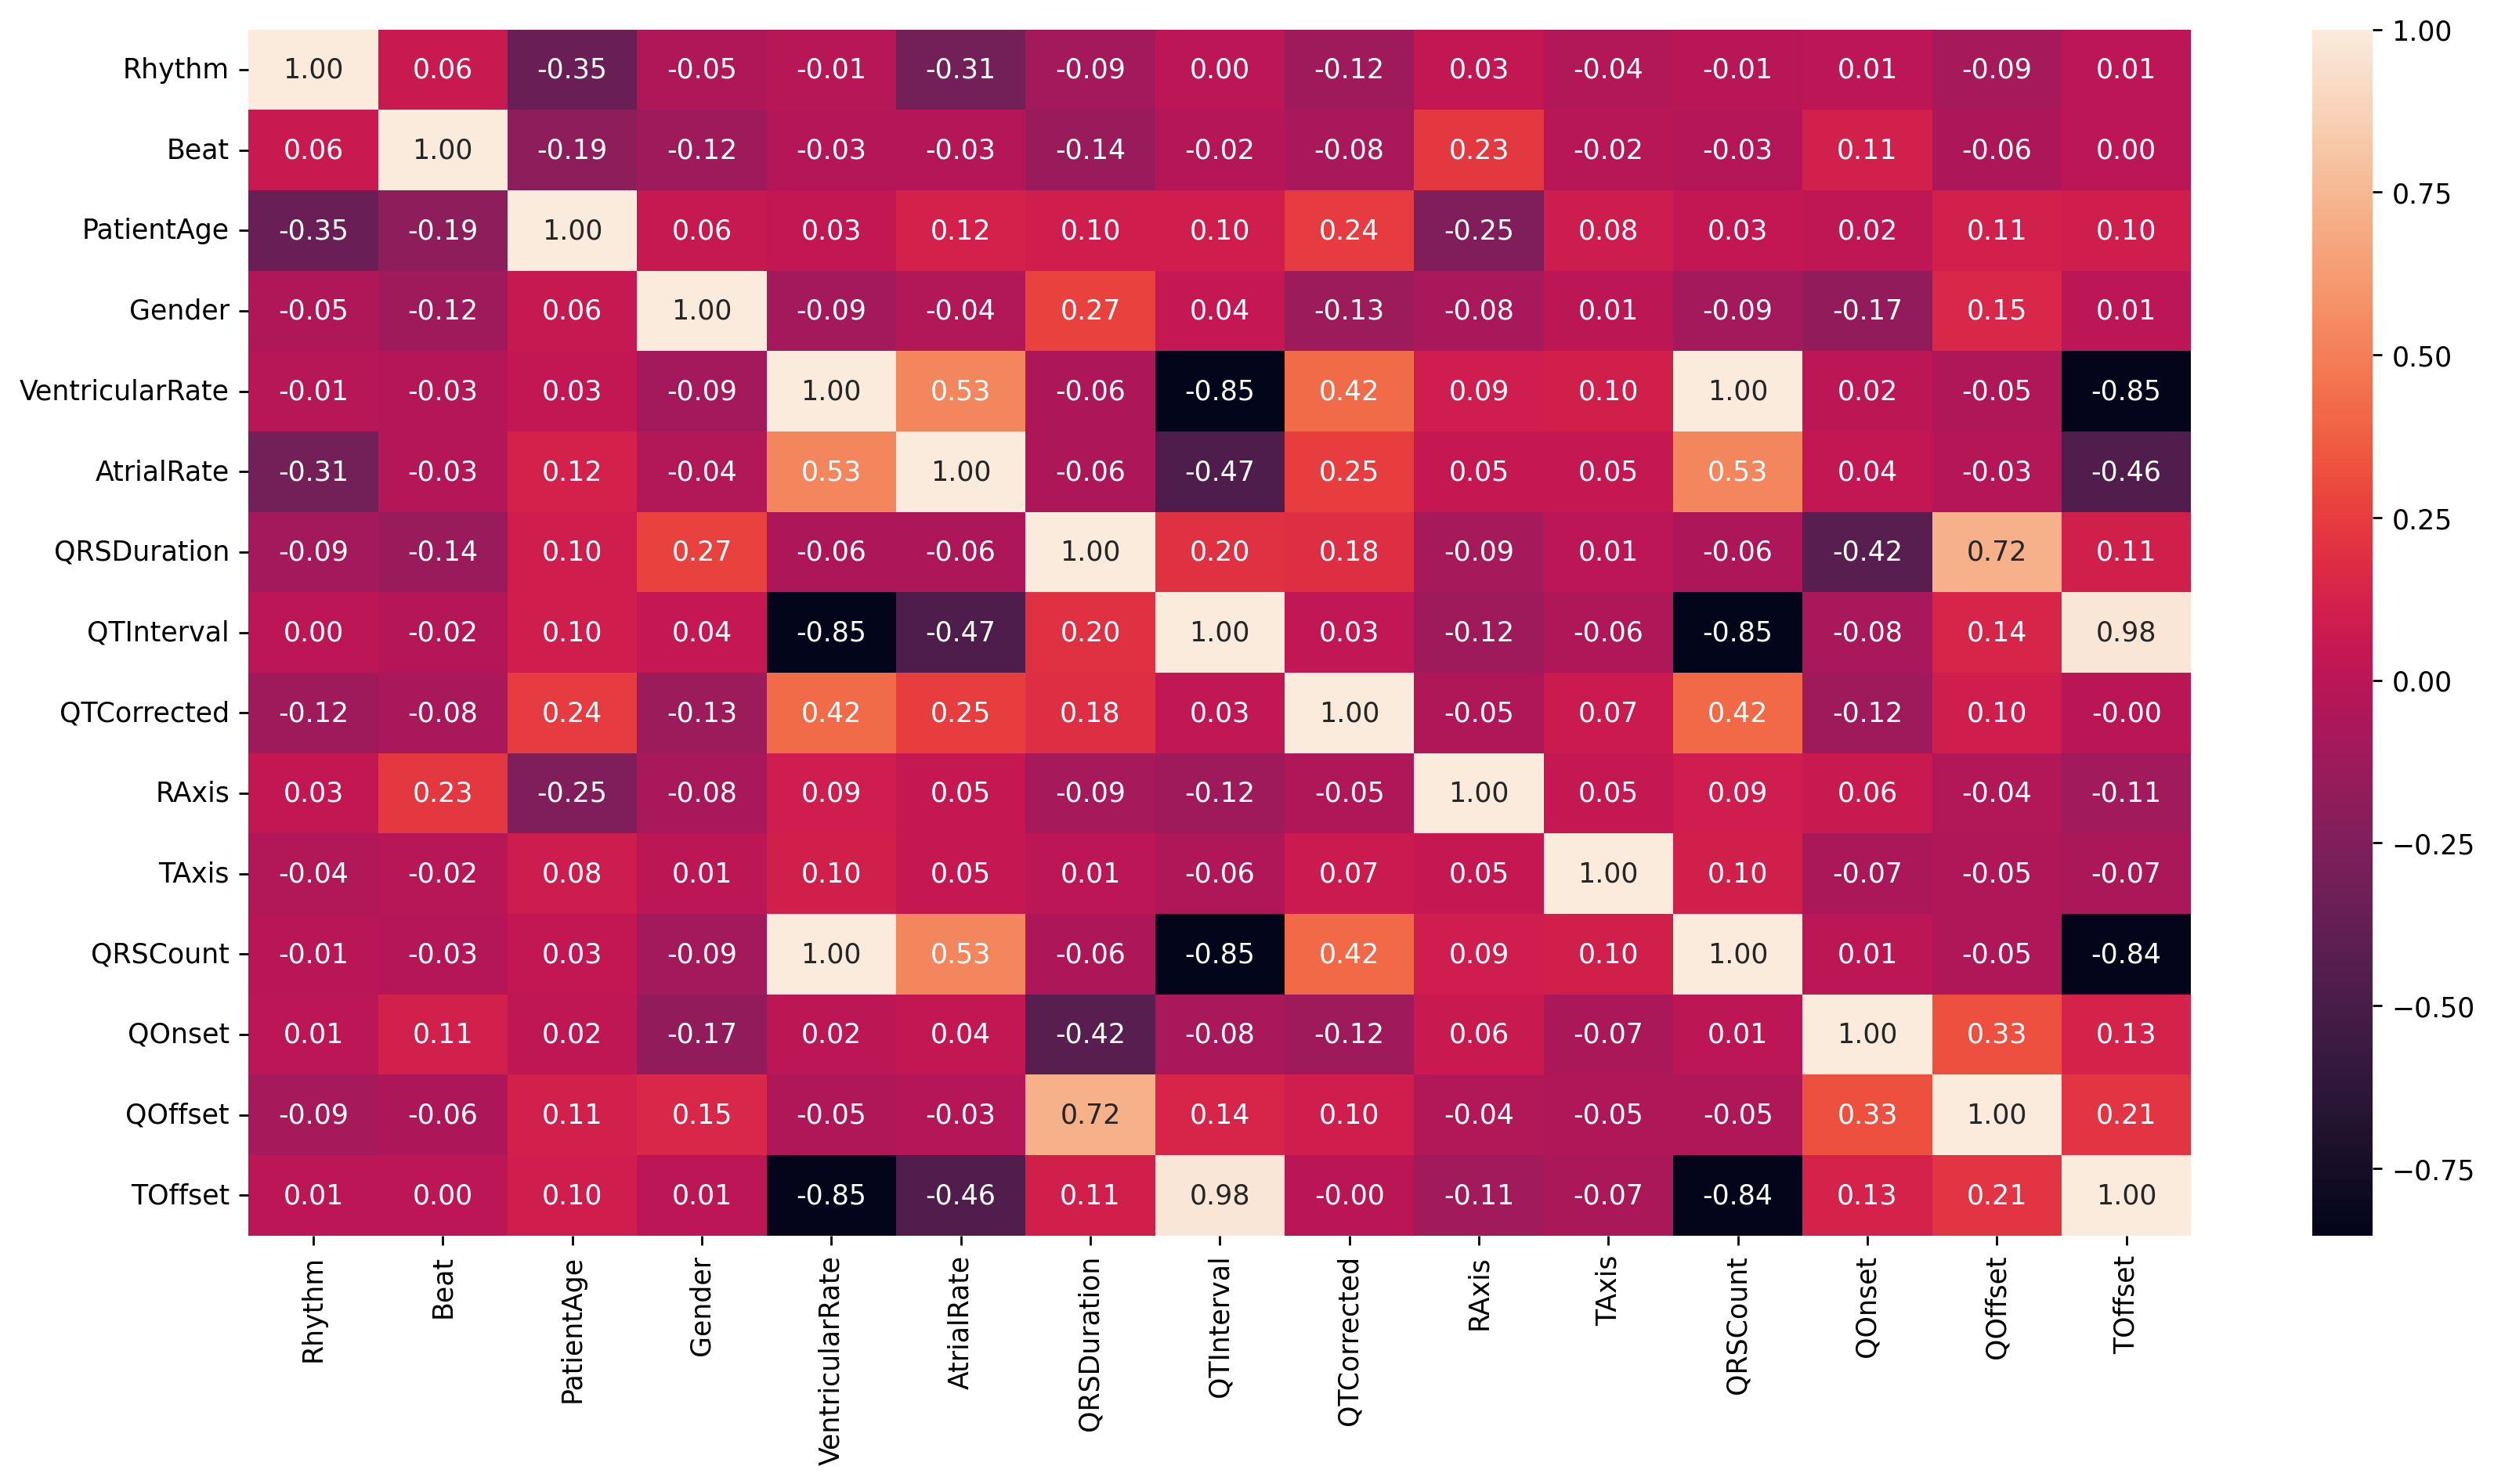

In [ ]:
import seaborn as sns

#correlation
corr = data.corr()

plt.figure(dpi=250,figsize=(16,8))
sns.heatmap(data.corr(), annot=True, fmt= '.2f')
plt.show()


In [ ]:
# Impact of each column on output
corr['Rhythm'].sort_values(ascending = False)

Rhythm             1.000000
Beat               0.064382
RAxis              0.031731
QOnset             0.006689
TOffset            0.005988
QTInterval         0.004575
QRSCount          -0.011870
VentricularRate   -0.014506
TAxis             -0.036244
Gender            -0.050991
QOffset           -0.092617
QRSDuration       -0.093823
QTCorrected       -0.115512
AtrialRate        -0.308386
PatientAge        -0.348862
Name: Rhythm, dtype: float64

In [ ]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# Standardize the features (optional, but recommended)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
# Reshape the data into a 3D tensor for use with an LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# Convert target labels to one-hot encoded format
num_classes = len(encoder.classes_)
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

In [ ]:
# Our model
# by adding two more conv layers after lstm

model = Sequential()

# CNN layer
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Conv1D(64, kernel_size=3, activation='sigmoid', input_shape=(X_train.shape[1], 1)))
# LSTM layer
model.add(LSTM(32, activation='relu', return_sequences=True))

# You can add more LSTM layers if needed
model.add(LSTM(32, activation='sigmoid', return_sequences=True))

# Two more cnn layers
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))

# MaxPooling layer
model.add(MaxPooling1D(pool_size=3))

# Flatten before the fully connected layers
model.add(layers.Flatten())

# Dense layers (fully connected)
model.add(layers.Dense(128, activation='sigmoid'))
model.add(layers.Dense(num_classes, activation='softmax'))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 12, 64)            256       
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 64)            12352     
                                                                 
 lstm (LSTM)                 (None, 10, 32)            12416     
                                                                 
 lstm_1 (LSTM)               (None, 10, 32)            8320      
                                                                 
 conv1d_2 (Conv1D)           (None, 8, 64)             6208      
                                                                 
 conv1d_3 (Conv1D)           (None, 6, 64)             12352     
                                                                 
 max_pooling1d (MaxPooling1  (None, 2, 64)             0

In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)

Epoch 1/100
250/250 [==============================] - 10s 21ms/step - loss: 1.5932 - accuracy: 0.4103 - val_loss: 1.0286 - val_accuracy: 0.6123
Epoch 2/100
250/250 [==============================] - 4s 17ms/step - loss: 0.9269 - accuracy: 0.6658 - val_loss: 0.7957 - val_accuracy: 0.7303
Epoch 3/100
250/250 [==============================] - 6s 23ms/step - loss: 0.7841 - accuracy: 0.7301 - val_loss: 0.7665 - val_accuracy: 0.7258
Epoch 4/100
250/250 [==============================] - 4s 17ms/step - loss: 0.7404 - accuracy: 0.7436 - val_loss: 0.7269 - val_accuracy: 0.7438
Epoch 5/100
250/250 [==============================] - 4s 17ms/step - loss: 0.7275 - accuracy: 0.7482 - val_loss: 0.7185 - val_accuracy: 0.7453
Epoch 6/100
250/250 [==============================] - 6s 25ms/step - loss: 0.6838 - accuracy: 0.7674 - val_loss: 0.6779 - val_accuracy: 0.7648
Epoch 7/100
250/250 [==============================] - 5s 19ms/step - loss: 0.6581 - accuracy: 0.7709 - val_loss: 0.6741 - val_accuracy

In [ ]:
# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

42/42 [==============================] - 1s 6ms/step


In [ ]:
# Compute classification report and confusion matrix
labels = encoder.classes_
classification_rep = classification_report(y_true, y_pred_classes, labels=range(num_classes), target_names=labels)
confusion_mat = confusion_matrix(y_true, y_pred_classes)

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy}')

42/42 [==============================] - 0s 9ms/step - loss: 0.5293 - accuracy: 0.8618
Test accuracy: 0.8617580533027649


In [ ]:
# Calculate recall, precision, specificity, and prevalence
recall = np.diag(confusion_mat) / np.sum(confusion_mat, axis=1)
precision = np.diag(confusion_mat) / np.sum(confusion_mat, axis=0)
#specificity = np.sum(np.delete(np.delete(confusion_mat, np.arange(num_classes), axis=0), np.arange(num_classes), axis=1) / np.sum(confusion_mat, axis=1))
prevalence = np.sum(confusion_mat, axis=1) / np.sum(confusion_mat)


# Printing the evaluation parameters
print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", confusion_mat)
print("Recall:", recall)
print("Precision:", precision)
print("Prevalence:", prevalence)

Classification Report:
               precision    recall  f1-score   support

          AF       0.50      0.07      0.12        45
        AFIB       0.85      0.80      0.82       216
          AT       0.00      0.00      0.00        15
       AVNRT       0.00      0.00      0.00         2
        AVRT       0.00      0.00      0.00         0
          SA       0.67      0.18      0.28        56
       SAAWR       0.00      0.00      0.00         3
          SB       0.98      0.98      0.98       501
          SR       0.75      0.97      0.85       221
          ST       0.83      0.96      0.89       211
         SVT       0.70      0.89      0.78        61

   micro avg       0.86      0.86      0.86      1331
   macro avg       0.48      0.44      0.43      1331
weighted avg       0.84      0.86      0.84      1331

Confusion Matrix:
 [[  3  12   0   0   0   0   1   8  13   8]
 [  1 173   0   0   0   0   5  11  15  11]
 [  1   5   0   0   0   0   0   3   4   2]
 [  0   0   0  